In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import os
DIR = "/home/rave/biophysics-course-2019/sedgwick-towers/ghg-tower-unzipped"

In [2]:
def clean_and_set_ind(df):
    df = df[df['U (m/s)']!=-9999]
    df = df[df['V (m/s)']!=-9999]
    df = df[df['W (m/s)']!=-9999]
    df['datetime'] = df.Date + '-' + df.Time
    df = df.set_index('datetime')
    #http://strftime.org/ for offest nicknames
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d-%H:%M:%S:%f')
    return df

def parse_data_file(file_path):
    """Takes a .data file (not ...biomet.data) and parses into a dataframe with the correct column names.
    If the tower setup changes (different instruments or configuration) then the column names should change"""
    
    column_names = ['DATAH', 'Seconds', 'Nanoseconds', 'Sequence Number', 'Diagnostic Value', 'Diagnostic Value 2',
                    'DS Diagnostic Value','Date','Time', 'CO2 Absorptance','H2O Absorptance','CO2 (mmol/m^3)', 
                    'CO2 (mg/m^3)','H2O (mmol/m^3)','H2O (g/m^3)', 'Temperature (C)', 'Pressure (kPa)', 
                    'Cooler Voltage (V)', 'Chopper Cooler Voltage (V)', 'Vin SmartFlux (V)', 'CO2 (umol/mol)', 
                    'H2O (mmol/mol)', 'Dew Point (C)', 'CO2 Signal Strength', 'H2O Sample', 'H2O Reference',
                    'CO2 Sample','CO2 Reference','Vin DSI (V)', 'U (m/s)', 'V (m/s)', 'W (m/s)', 'T (C)', 
                    'Anemometer Diagnostics', 'CHK']

    df = pd.read_csv(file_path,  delim_whitespace=True, skiprows=7)

    df = df.dropna(axis=1, how='all')
    
    df.columns = column_names
    
    return clean_and_set_ind(df)


def u_star(df):
    """
    u_star as calculated from the 3D velocities by Stull 1998
    https://journals.ametsoc.org/doi/full/10.1175/JAS-D-16-0282.1
    u w and v are pandas series of the deviations from mean wind velocity
    returns a pandas series
    """
    
    wind_means = df.loc[:, ['U (m/s)','V (m/s)','W (m/s)']].resample('30min').mean().resample('1S').ffill()
    wind_means.columns = ['Umean', 'Vmean', 'Wmean']
    df = df.join(wind_means)
    # deviations from mean,need to fill last half hour withfinal mean that is not ffilled
    df['U`'] = df['U (m/s)']-df['Umean'].fillna(wind_means['Umean'].iloc[-1])
    df['V`'] = df['V (m/s)']-df['Vmean'].fillna(wind_means['Vmean'].iloc[-1])
    df['W`'] = df['W (m/s)']-df['Wmean'].fillna(wind_means['Wmean'].iloc[-1])
    # product of deviations of horizontal components and vertical component
    uw = df['U`']*df['W`']
    vw = df['V`']*df['W`']
    #calc covariances
    uw_covs = uw.resample('30min').mean()
    vw_covs = vw.resample('30min').mean()
    # solve for u_star
    return ((uw_covs)**2 + (vw_covs)**2)**(.25)

In [3]:
march_26_T16 = parse_data_file("sedgwick-towers/ghg-tower-unzipped/2019-03-26T160000_smart3-00265.data")

march_26_T04 = parse_data_file("sedgwick-towers/ghg-tower-unzipped/2019-03-26T040000_smart3-00265.data")

march_26_T00 = parse_data_file("sedgwick-towers/ghg-tower-unzipped/2019-03-26T000000_smart3-00265.data")

march_26_T08 = parse_data_file("sedgwick-towers/ghg-tower-unzipped/2019-03-26T080000_smart3-00265.data")

march_26_T12 = parse_data_file("sedgwick-towers/ghg-tower-unzipped/2019-03-26T120000_smart3-00265.data")

Something is wrong with the twoer data, first values in each 4 hour block are missing

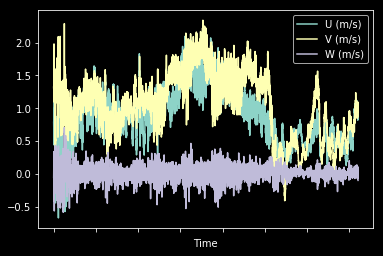

In [7]:
plt.style.use('dark_background')
march_26_T00.plot(x='Time', y=['U (m/s)', 'V (m/s)', 'W (m/s)'])

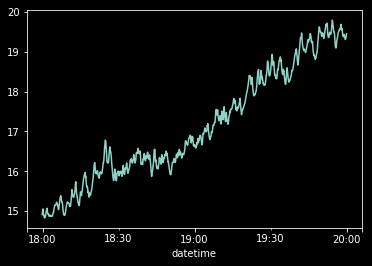

In [9]:
march_26_T16['Temperature (C)'].plot()

In [11]:
march_26_T16

,DATAH,Seconds,Nanoseconds,Sequence Number,Diagnostic Value,Diagnostic Value 2,DS Diagnostic Value,Date,Time,CO2 Absorptance,...,H2O Reference,CO2 Sample,CO2 Reference,Vin DSI (V),U (m/s),V (m/s),W (m/s),T (C),Anemometer Diagnostics,CHK
datetime,,,,,,,,,,,,,,,,,,,,,
2019-03-26 17:59:51,DATA,1553623191,0,305740380,253,1,0,2019-03-26,17:59:51:000,0.135528,...,45564.2,24467.1,30741.2,11.9096,-1.429690,-1.992190,0.448594,16.1020,0,143
2019-03-26 17:59:52,DATA,1553623192,0,305740680,253,1,0,2019-03-26,17:59:52:000,0.136323,...,45565.4,24449.1,30741.6,11.9096,-2.197030,-1.744630,0.421810,15.5238,0,89
2019-03-26 17:59:53,DATA,1553623193,0,305740980,253,1,0,2019-03-26,17:59:53:000,0.136240,...,45568.1,24457.8,30738.1,11.9096,-2.372870,-1.657290,0.176786,15.9108,0,63
2019-03-26 17:59:54,DATA,1553623194,0,305741280,253,1,0,2019-03-26,17:59:54:000,0.136199,...,45564.2,24468.5,30742.9,11.9096,-1.803880,-1.434580,0.695686,16.1959,0,2
2019-03-26 17:59:55,DATA,1553623195,0,305741580,253,1,0,2019-03-26,17:59:55:000,0.135138,...,45561.1,24488.9,30741.7,11.9103,-1.579580,-1.310330,0.920865,17.2473,0,167
2019-03-26 17:59:56,DATA,1553623196,0,305741880,253,1,0,2019-03-26,17:59:56:000,0.135391,...,45559.3,24474.7,30740.0,11.9109,-1.654700,-1.438110,0.494751,16.5198,0,6
2019-03-26 17:59:57,DATA,1553623197,0,305742180,253,1,0,2019-03-26,17:59:57:000,0.136318,...,45565.3,24455.9,30744.8,11.9109,-1.935200,-1.269790,0.407650,15.6083,0,151
2019-03-26 17:59:58,DATA,1553623198,0,305742480,253,1,0,2019-03-26,17:59:58:000,0.136474,...,45566.0,24457.6,30741.8,11.9103,-1.579110,-1.997770,-0.288952,15.5367,0,90
2019-03-26 17:59:59,DATA,1553623199,0,305742780,253,1,0,2019-03-26,17:59:59:000,0.135743,...,45562.5,24475.0,30741.5,11.9103,-1.526490,-1.739410,0.012120,16.1861,0,135


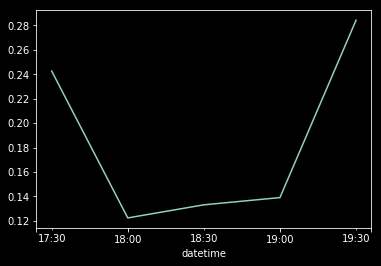

In [10]:
u_star(march_26_T16).plot()

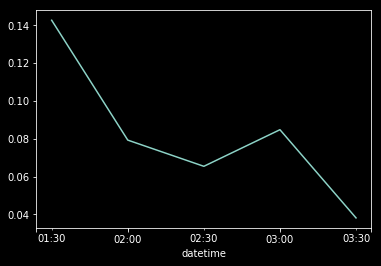

In [81]:
plt.style.use('dark_background')
u_star(march_26_T00).plot()

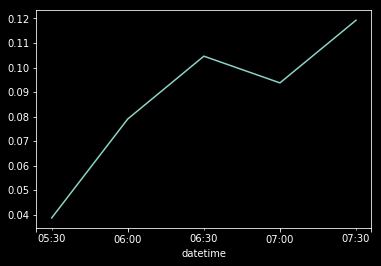

In [82]:
u_star(march_26_T04).plot()

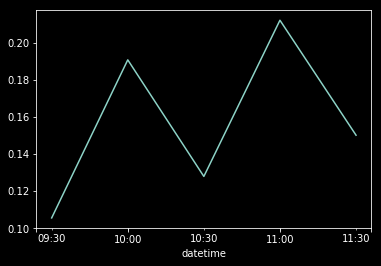

In [94]:
u_star(march_26_T08).plot()